### **FINAL MODEL (aumented bacth since when it was reduced the model worsen)**
- ### Aumented batch to 448 
- ### Reduced dropout to 0.15


### Import Required Libraries

In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-Spanish sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/NLP_Julia

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/NLP_Julia


In [0]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)[:,0:2] #NOS QUEDAMOS SOLO CON LAS PRIMERAS COLUMNAS QUE TIENEN LA INFORMACION

The actual data contains over 150,000 sentence-pairs. However, we will use the first 80,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
#PARA ENTRENAR EL PRIMER MODELO VOY A USARLAS TODAS ASI QUE COMENTO ESTA LINEA
spa_eng = spa_eng[:80000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [0]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Suddenly, all the lights went out.',
        'De repente se apagaron todas las luces.'],
       ['Suddenly, the dog started barking.',
        'De repente el perro empezó a ladrar.'],
       ['Swimming in the pond is dangerous.',
        'Es peligroso nadar en la laguna.']], dtype='<U332')

We will get rid of the punctuation marks, and then convert the text to lower case.

#### *IMPORTANTE QUITAR LA EXCLAMACION HACIA ARRIBA PARA EL ESPAÑOL



In [0]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

## TAMBIEN QUITAMOS ESTA EXCLAMACION QUE LO ANTERIOR NO LO QUITA
spa_eng[:,0] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', '¡')) for s in spa_eng[:,1]]

# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [0]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['suddenly all the lights went out',
        'de repente se apagaron todas las luces'],
       ['suddenly the dog started barking',
        'de repente el perro empezó a ladrar'],
       ['swimming in the pond is dangerous',
        'es peligroso nadar en la laguna']], dtype='<U332')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish, respectively.

In [0]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [0]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
#print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

10
15


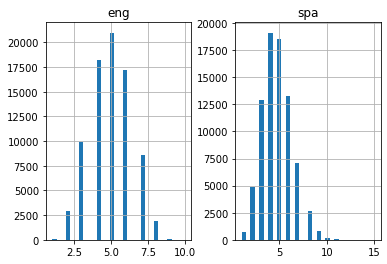

In [0]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the Spanish sentences is 15 and that of the English phrases is 10.


Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [0]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 15
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9440


In [0]:
# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 15
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 18823


In [0]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 171), ('vete', 47), ('vaya', 91), ('váyase', 8), ('hola', 25), ('corre', 28), ('corran', 4), ('corra', 3), ('corred', 4), ('¿quién', 487), ('órale', 10), ('fuego', 73), ('incendio', 17), ('disparad', 3), ('ayuda', 283), ('socorro', 2), ('auxilio', 3), ('salta', 4), ('salte', 2), ('parad', 2), ('para', 1494), ('pare', 11), ('espera', 99), ('esperen', 11), ('continúa', 17), ('continúe', 9), ('corrí', 15), ('corría', 6), ('lo', 3689), ('intento', 18), ('he', 798), ('ganado', 25), ('oh', 15), ('no', 11128), ('tomátelo', 2), ('con', 2084), ('soda', 3), ('disparen', 1), ('dispara', 1), ('dispará', 1), ('dispare', 3), ('sonríe', 9), ('al', 1378), ('ataque', 18), ('atacad', 1), ('ataquen', 1), ('ataca', 1), ('levanta', 29), ('ahora', 743), ('mismo', 281), ('id', 7), ('vayan', 13), ('ya', 613), ('tengo', 1455), ('¿lo', 71), ('pillas', 1), ('¿entendiste', 6), ('él', 4305), ('corrió', 38), ('métete', 6), ('adentro', 32), ('abrázame', 1), ('me', 5028), ('caí', 7), ('yo', 1866),

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [0]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[  11  246    4 ...    0    0    0]
 [  93   15    7 ...    0    0    0]
 [  40    6    4 ...    0    0    0]
 ...
 [  14  292  100 ...    0    0    0]
 [  52  250 2008 ...    0    0    0]
 [  18  127 1589 ...    0    0    0]]
64000
[[   1  223    2 ...    0    0    0]
 [ 388    5 1608 ...    0    0    0]
 [  12    7   92 ...    0    0    0]
 ...
 [   2  117   10 ...    0    0    0]
 [  55  480  576 ...    0    0    0]
 [  13  165  850 ...    0    0    0]]
64000


In [0]:
print(trainX.shape)
print(trainY.shape)

(64000, 15)
(64000, 15)


In [0]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[   1  946 7114 ...    0    0    0]
 [  25 6256    0 ...    0    0    0]
 [ 747   33  121 ...    0    0    0]
 ...
 [   3    1    2 ...    0    0    0]
 [ 189  236  451 ...    0    0    0]
 [7627 3437 2486 ...    0    0    0]]
16000
[[   3  350   33 ...    0    0    0]
 [1172   10    0 ...    0    0    0]
 [  57   62   97 ...    0    0    0]
 ...
 [   3   87   29 ...    0    0    0]
 [ 133    1   59 ...    0    0    0]
 [  90  856   24 ...    0    0    0]]
16000


In [0]:
print(testX.shape)
print(testY.shape)

(16000, 15)
(16000, 15)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [0]:
# build NMT model (LSTM)
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.15))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [0]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

18823
9440
15
15


In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 35 epochs and with a batch size of 448. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [0]:
filename = 'modelLSTM6.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=35, batch_size=448, #512 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 51200 samples, validate on 12800 samples
Epoch 1/35
51200/51200 [==============================] - 64s 1ms/step - loss: 2.4176 - val_loss: 2.0813

Epoch 00001: val_loss improved from inf to 2.08126, saving model to modelLSTM6.h1
Epoch 2/35
51200/51200 [==============================] - 61s 1ms/step - loss: 2.0021 - val_loss: 1.9813

Epoch 00002: val_loss improved from 2.08126 to 1.98130, saving model to modelLSTM6.h1
Epoch 3/35
51200/51200 [==============================] - 62s 1ms/step - loss: 1.8929 - val_loss: 1.8957

Epoch 00003: val_loss improved from 1.98130 to 1.89571, saving model to modelLSTM6.h1
Epoch 4/35
51200/51200 [==============================] - 61s 1ms/step - loss: 1.7812 - val_loss: 1.7707

Epoch 00004: val_loss improved from 1.89571 to 1.77068, saving model to modelLSTM6.h1
Epoch 5/35
51200/51200 [==============================] - 61s 1ms/step - loss: 1.6589 - val_loss: 1.6692

Epoch 00005: val_loss improved from 1.77068 to 1.66923, saving model to modelLST

Let's compare the training loss and the validation loss.

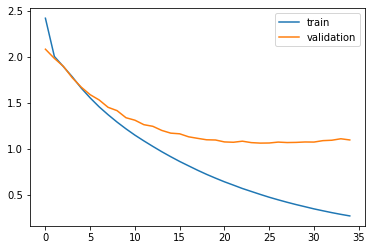

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [0]:
model = load_model('modelLSTM6.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'Spanish':  test[:,1], 'actual traduction' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.head(15)

,Spanish,actual traduction,predicted
0,tom sentía temblar sus rodillas,tom felt his knees tremble,tom felt his
1,eso valdrá,thatll do,thatll do
2,volveré más tarde,ill come back later,ill be later
3,estoy reventado,i am exhausted,im exhausted
4,no lo hagáis,dont do it,dont ask it
5,me duele la muela del juicio superior derecha,my upper right wisdom tooth hurts,i have missing point
6,ya lo has olvidado,youve already forgotten,youve already it
7,¿por qué llevas un suéter,why are you wearing a sweater,why are you wearing a dress
8,no me subestimes,dont underestimate me,dont ask me
9,eso fue idea mía,it was my idea,that was my idea


In [0]:
pred_df.sample(15)

,Spanish,actual traduction,predicted
14611,tom estuvo ahí esa noche,tom was there that night,tom was there last night
3236,a veces los sueños se hacen realidad,dreams sometimes come true,sometimes i dont tom
258,ella limpió la pieza,she cleaned the room,she closed the room
2498,no estás intentando lo suficiente,youre not trying hard enough,youre not have to enough
9668,estoy borracho,im sloshed,im drunk
10734,le pedí que empezara de una vez,i asked him to start at once,i asked him to leave a alone
9856,eso no cambiaría nada,that wouldnt change a thing,that doesnt nothing anything
2193,tomás volverá pronto,tom will soon be back,tom will come back soon
12067,la habitación estaba vacía,the room was empty,the room was empty
3213,siento algo,i feel something,im feel something


The error in this model (1.06087) is a little higher than in our best model LSTM3 (1.05608). Nevertheless, the difference is minimun and we still get pretty good translations. For example in line 9669 it translates "im drunk" to "estoy borracho" which is correct although the actual transation was "im sloshed". Therefore the model is doing really well in learning from the context and we are getting pretty good transations for the little training that we did.